In [1]:
# do not run when we import this package as module
if __name__ == '__main__':
  # Connect Google Drive
  from google.colab import drive
  drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [2]:
# Common
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from IPython.display import clear_output as cls
import datetime
from collections import Counter

# Data
from tqdm import tqdm
from glob import glob
import tensorflow.data as tfd

# Data Visualization
import cv2
from PIL import Image
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# Model
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras import applications as tka
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [3]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [4]:
# Clear any logs from previous runs
!rm -rf /content/gdrive/MyDrive/OWR/log/OCR_Model5/

In [5]:
!pip install keras_tuner
import keras_tuner as kt
cls()

In [6]:
!pip install opendatasets
cls()

In [8]:
import opendatasets as od

# Specify the Kaggle dataset URL
dataset_url = 'https://www.kaggle.com/datasets/harieh/ocr-dataset/data'

# Download the dataset to the specified folder
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: sachithgunawardane
Your Kaggle Key: ··········


100%|██████████| 153M/153M [00:05<00:00, 31.5MB/s]


In [9]:
# The batch size
BATCH_SIZE = 64

# Image dims
IMAGE_SIZE = (60,40)                                    # Even this will work

# Buffer size
BUFFER = 1000

# Autotuning
AUTOTUNE = tfd.AUTOTUNE

In [10]:
# Setting the Random Seeds
np.random.seed(1024)
tf.random.set_seed(1024)

In [11]:
# Specify the root paths
database_path = '/content/ocr-dataset/dataset'

tensorboard_log_dir = "/content/gdrive/MyDrive/OWR/log/OCR_Model5/"
model_dir = "/content/gdrive/MyDrive/OWR/dl_models/OCR_Model5/"
figure_dir = "/content/gdrive/MyDrive/OWR/figures/OCR_Model5/"

In [11]:
# # Map subdirectories to desired class names
# class_mapping = {
#     '0' : '0','1' : '1', '2' : '2', '3' : '3', '4' : '4', '5' : '5', '6' : '6', '7' : '7', '8' : '8', '9' : '9',
#     'A_U': 'A', 'B_U': 'B', 'C_U': 'C', 'D_U': 'D', 'E_U': 'E', 'F_U': 'F', 'G_U': 'G', 'H_U': 'H', 'I_U': 'I', 'J_U': 'J', 'K_U': 'K', 'L_U': 'L', 'M_U': 'M', 'N_U': 'N', 'O_U': 'O', 'P_U': 'P', 'Q_U': 'Q', 'R_U': 'R', 'S_U': 'S', 'T_U': 'T', 'U_U': 'U', 'V_U': 'V', 'W_U': 'W', 'X_U': 'X', 'Y_U': 'Y', 'Z_U': 'Z',
#     'a_L': 'A', 'b_L': 'B', 'c_L': 'C', 'd_L': 'D', 'e_L': 'E', 'f_L': 'F', 'g_L': 'G', 'h_L': 'H', 'i_L': 'I', 'j_L': 'J', 'k_L': 'K', 'l_L': 'L', 'm_L': 'M', 'n_L': 'N', 'o_L': 'O', 'p_L': 'P', 'q_L': 'Q', 'r_L': 'R', 's_L': 'S', 't_L': 'T', 'u_L': 'U', 'v_L': 'V', 'w_L': 'W', 'x_L': 'X', 'y_L': 'Y', 'z_L': 'Z'
#     # Add more mappings as needed
# }

# class_names = [ '0', '1',  '2', '3',  '4', '5',  '6',  '7',  '8',  '9',
#                 'A', 'B',  'C', 'D', 'E',  'F',  'G', 'H',  'I',  'J',  'K',  'L',  'M', 'N',  'O',  'P',  'Q', 'R',  'S',  'T', 'U', 'V',  'W',  'X', 'Y',  'Z',
#                 'A', 'B',  'C', 'D', 'E',  'F',  'G', 'H',  'I',  'J',  'K',  'L',  'M', 'N',  'O',  'P',  'Q', 'R',  'S',  'T', 'U', 'V',  'W',  'X', 'Y',  'Z']


# # Get the list of subdirectories in the data directory
# subdirectories = [d for d in os.listdir(database_path) if os.path.isdir(os.path.join(database_path, d))]

# # Ensure that the class_names exactly match the subdirectories
# class_names = [class_mapping.get(subdir, subdir) for subdir in subdirectories]

In [12]:
# Use image_dataset_from_directory with class_names parameter
# dataset = tf.keras.utils.image_dataset_from_directory(
#     database_path,
#     labels="inferred",
#     batch_size=BATCH_SIZE,
#     image_size=IMAGE_SIZE,
#     shuffle=True,
#     seed=42,
#     color_mode="grayscale"
# )


dataset = tf.keras.utils.image_dataset_from_directory(
    database_path,
    labels="inferred",
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=True,
    seed=42,
    color_mode="rgb"
)


Found 210227 files belonging to 62 classes.


In [13]:
data_iter = dataset.as_numpy_iterator()
data_iter

In [14]:
batch = data_iter.next()

In [15]:
print(len(batch),batch[1],batch[0].shape)
print(dataset.class_names)
class_names = dataset.class_names

2 [41 54 52 53  0 17  7  9  4 40 45 37 54 45 32 19 12 11 32 42  6 36  7 48
 20 60  9 44 51 38 59 51  9  7 54 13 55 38 41 55 24 42 51 25 23 27 12 36
 37  8 26 24 56 43 51 33 54 48 45  7 40 13 31 27] (64, 60, 40, 3)
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A_U', 'B_U', 'C_U', 'D_U', 'E_U', 'F_U', 'G_U', 'H_U', 'I_U', 'J_U', 'K_U', 'L_U', 'M_U', 'N_U', 'O_U', 'P_U', 'Q_U', 'R_U', 'S_U', 'T_U', 'U_U', 'V_U', 'W_U', 'X_U', 'Y_U', 'Z_U', 'a_L', 'b_L', 'c_L', 'd_L', 'e_L', 'f_L', 'g_L', 'h_L', 'i_L', 'j_L', 'k_L', 'l_L', 'm_L', 'n_L', 'o_L', 'p_L', 'q_L', 'r_L', 's_L', 't_L', 'u_L', 'v_L', 'w_L', 'x_L', 'y_L', 'z_L']


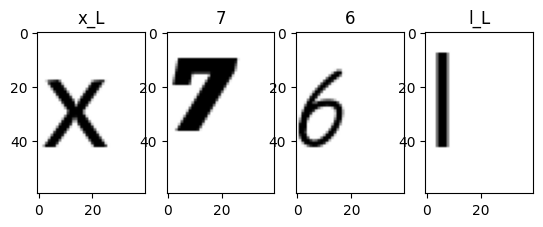

In [16]:
fig, ax = plt.subplots(1,4)

# Alternate way to view plots from tensorflow docs
for images, labels in dataset.take(1):
    for i in range(4):
        ax[i].imshow(images[i].numpy().astype(int))
        ax[i].set_title(class_names[labels[i]])


In [17]:
dataset = dataset.map(lambda x,y:(x/255,y))

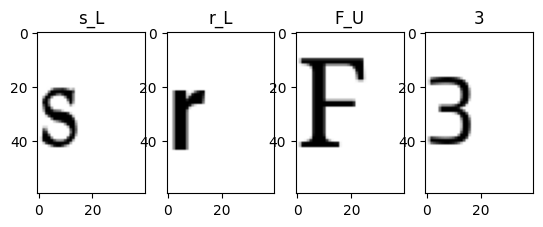

In [18]:
fig, ax = plt.subplots(1,4)
for images, labels in dataset.take(1):
    for i in range(4):
        ax[i].imshow(images[i].numpy())
        ax[i].set_title(class_names[labels[i]])
plt.show()

In [19]:
# Extract features (X) and labels (y) from the dataset
X = []
y = []
for images, labels in dataset:
    X.extend(images.numpy())
    y.extend(labels.numpy())

# Convert lists to NumPy arrays
X = np.array(X)
y = np.array(y)

In [20]:


# Split the data into training (70%), validation (20%), and testing (10%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=1/3, stratify=y_temp, random_state=42)

# Print the sizes of the resulting sets
print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Testing set size: {len(X_test)}")


Training set size: 147158
Validation set size: 42046
Testing set size: 21023


In [38]:
def build_model(hp):

 # Initialize the model in sequential
  model = keras.Sequential()
  # Adding first convolutional layer
  model.add(layers.Conv2D(
      filters=hp.Int('conv_1_filter', min_value=64, max_value=256, step=64),
      kernel_size=hp.Choice('conv_1_kernel', values=[3,5]),
      activation='relu',
      input_shape=(*IMAGE_SIZE,1)
  ))
  # Adding first pooling layer
  model.add(layers.AvgPool2D(
      pool_size=(hp.Int('pool_1_size', min_value=2, max_value=3, step=1),
      hp.Int('pool_1_size', min_value=2, max_value=3, step=1))
  ))

  # Adding multiple convolutional and pooling layers
  for i in range(hp.Choice('n_conv_layers', values=[1,2,3])):
    model.add(layers.Conv2D(
        filters=hp.Int(f'conv_{i+2}_filter', min_value=64, max_value=256, step=64),
        kernel_size=hp.Choice(f'conv_{i+2}_kernel', values=[3,5]),
        activation='relu',
    ))
    model.add(layers.AvgPool2D(
        pool_size=(hp.Int(f'pool_{i+2}_size', min_value=2, max_value=3, step=1),
        hp.Int(f'pool_{i+1}_size', min_value=2, max_value=3, step=1))
    ))

  model.add(layers.GlobalAveragePooling2D())

  # Adding multiple FC layers
  for i in range(hp.Int('n_FC_layers', min_value=1, max_value=3, step=1)):
    model.add(layers.Dense(hp.Choice(f'{i+1}_FC_layer', values=[64, 128, 256]),
                           activation='relu'))
    model.add(layers.Dropout(hp.Choice(f'{i+1}_dropout_layer', values=[0.2, 0.3, 0.5])))
  #model.add(layers.BatchNormalization())

  # Adding output layer
  model.add(layers.Dense(len(class_names), activation='softmax'))


  # Compile the model
  model.compile(loss='sparse_categorical_crossentropy',
                optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                metrics=['accuracy'])

  return model

In [40]:
# Initialize tuner
tuner = kt.RandomSearch(hypermodel=build_model, objective='val_accuracy', project_name='OCR-5-2')

# Start hyperparameter search.
tuner.search(X_train, y_train,
             validation_data=(X_val, y_val),
             epochs=3,  # Adjust as needed
             batch_size=BATCH_SIZE)

Trial 10 Complete [00h 00m 00s]

Best val_accuracy So Far: 0.7872092723846436
Total elapsed time: 00h 08m 59s


In [41]:
best_hps = tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values


for key, value in best_hps.items():
    print(f"{key}: {value}")

conv_1_filter: 64
conv_1_kernel: 5
pool_1_size: 2
n_conv_layers: 2
conv_2_filter: 192
conv_2_kernel: 3
pool_2_size: 3
n_FC_layers: 1
1_FC_layer: 64
1_dropout_layer: 0.5
learning_rate: 0.0001
conv_3_filter: 192
conv_3_kernel: 5
pool_3_size: 3
2_FC_layer: 128
2_dropout_layer: 0.5


In [44]:
# Get the best model and build it
best_model = tuner.get_best_models()[0]
best_model.build(input_shape=(*IMAGE_SIZE, 1))

# Best Model Summary
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 56, 36, 64)        1664      
                                                                 
 average_pooling2d (Average  (None, 28, 18, 64)        0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 16, 192)       110784    
                                                                 
 average_pooling2d_1 (Avera  (None, 8, 8, 192)         0         
 gePooling2D)                                                    
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 192)         921792    
                                                                 
 average_pooling2d_2 (Avera  (None, 1, 1, 192)         0

In [45]:
# Training the model
history = best_model.fit(X_train, y_train,
                         validation_data=(X_val, y_val),
                         epochs=100,
                         callbacks = [
        callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        callbacks.ModelCheckpoint(f'{model_dir}model_ocr_v5.h5', save_best_only=True),
        callbacks.TensorBoard(f'{tensorboard_log_dir}{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}', histogram_freq=1)
    ]
)

Epoch 1/100
4593/4599 [============================>.] - ETA: 0s - loss: 1.2041 - accuracy: 0.6728

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4599/4599 [==============================] - 38s 8ms/step - loss: 1.2040 - accuracy: 0.6729 - val_loss: 0.7455 - val_accuracy: 0.8112
Epoch 2/100
4599/4599 [==============================] - 35s 8ms/step - loss: 1.0180 - accuracy: 0.7219 - val_loss: 0.6528 - val_accuracy: 0.8311
Epoch 3/100
4599/4599 [==============================] - 35s 8ms/step - loss: 0.9091 - accuracy: 0.7529 - val_loss: 0.5824 - val_accuracy: 0.8477
Epoch 4/100
4599/4599 [==============================] - 35s 8ms/step - loss: 0.8344 - accuracy: 0.7715 - val_loss: 0.5449 - val_accuracy: 0.8594
Epoch 5/100
4599/4599 [==============================] - 35s 8ms/step - loss: 0.7755 - accuracy: 0.7894 - val_loss: 0.5280 - val_accuracy: 0.8600
Epoch 6/100
4599/4599 [==============================] - 35s 8ms/step - loss: 0.7264 - accuracy: 0.8017 - val_loss: 0.4991 - val_accuracy: 0.8683
Epoch 7/100
4599/4599 [==============================] - 35s 8ms/step - loss: 0.6891 - accuracy: 0.8108 - val_loss: 0.4902 - val_accurac

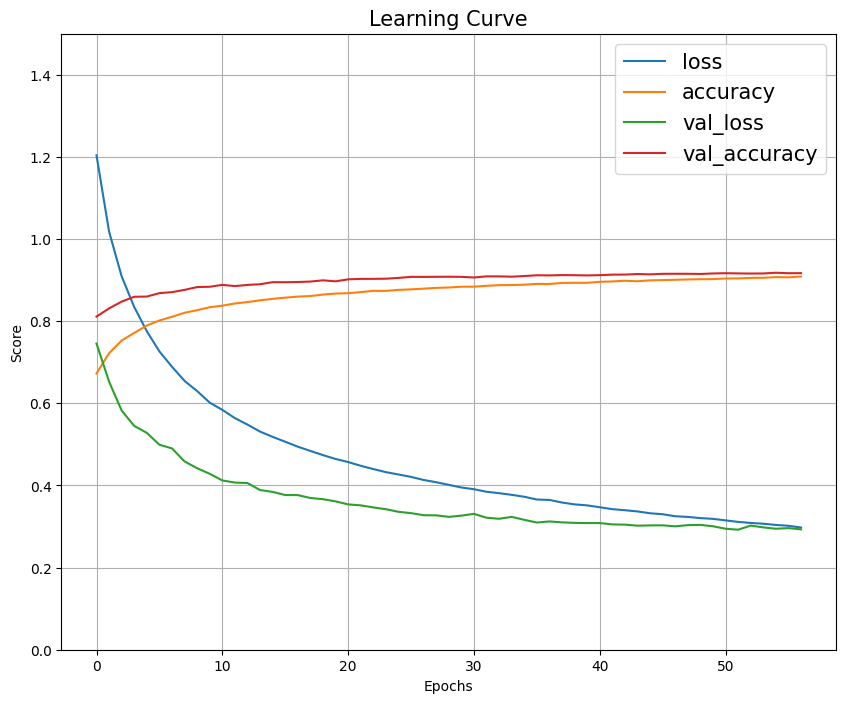

In [46]:
pd.DataFrame(history.history).plot(figsize=(10,8))
plt.title("Learning Curve", fontsize=15)
plt.legend(fontsize=15)
plt.ylim([0,1.5])
plt.ylabel('Score')
plt.xlabel('Epochs')
plt.grid()
plt.show()

In [47]:
# Valid Data
score = best_model.evaluate(X_val, y_val)

print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

1314/1314 [==============================] - 4s 3ms/step - loss: 0.2923 - accuracy: 0.9163
Validation loss: 0.2922738492488861
Validation accuracy: 0.9163297414779663


In [48]:
# Test data
score = best_model.evaluate(X_test, y_test)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

657/657 [==============================] - 2s 3ms/step - loss: 0.2878 - accuracy: 0.9157
Test loss: 0.2877987325191498
Test accuracy: 0.9156637787818909


In [49]:
model = keras.Sequential([
  keras.layers.Conv2D(32, 3, activation='relu', input_shape=(60,40,1),padding="same"), # padding is applied
    # Each filter is of dimension 3,3,1
  keras.layers.AveragePooling2D(pool_size=(2,2)), # The maximum value of 2x2 sub-matrix is taken

  keras.layers.Conv2D(32, 3, activation='relu'),
  keras.layers.AveragePooling2D(pool_size=2, padding="valid"),

  keras.layers.Conv2D(32, 3, activation='relu'),
  keras.layers.AveragePooling2D(pool_size=2, padding="valid"),

  keras.layers.Flatten(),
  keras.layers.Dense(62, activation='softmax') # changed to have 62 neurons (same as number of classes) and 'softmax' activation
])

In [50]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 60, 40, 32)        320       
                                                                 
 average_pooling2d_3 (Avera  (None, 30, 20, 32)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 18, 32)        9248      
                                                                 
 average_pooling2d_4 (Avera  (None, 14, 9, 32)         0         
 gePooling2D)                                                    
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 7, 32)         9248      
                                                                 
 average_pooling2d_5 (Avera  (None, 6, 3, 32)         

In [51]:
# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # sparse categorical entropy in case of softmax acti. func.
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [52]:
# Training the model
history_H = model.fit(X_train, y_train,
                         validation_data=(X_val, y_val),
                         epochs=50,
                         callbacks = [
        callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        callbacks.ModelCheckpoint(f'{model_dir}model_ocr_v5_1.h5', save_best_only=True),
        callbacks.TensorBoard(f'{tensorboard_log_dir}{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}', histogram_freq=1)
    ]
)

Epoch 1/50
4599/4599 [==============================] - 22s 5ms/step - loss: 1.0799 - accuracy: 0.7466 - val_loss: 0.6782 - val_accuracy: 0.8347
Epoch 2/50
  29/4599 [..............................] - ETA: 17s - loss: 0.6194 - accuracy: 0.8524

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4599/4599 [==============================] - 21s 5ms/step - loss: 0.5838 - accuracy: 0.8547 - val_loss: 0.5364 - val_accuracy: 0.8651
Epoch 3/50
4599/4599 [==============================] - 21s 5ms/step - loss: 0.4809 - accuracy: 0.8766 - val_loss: 0.4684 - val_accuracy: 0.8804
Epoch 4/50
4599/4599 [==============================] - 20s 4ms/step - loss: 0.4265 - accuracy: 0.8877 - val_loss: 0.4476 - val_accuracy: 0.8846
Epoch 5/50
4599/4599 [==============================] - 21s 4ms/step - loss: 0.3918 - accuracy: 0.8953 - val_loss: 0.4219 - val_accuracy: 0.8889
Epoch 6/50
4599/4599 [==============================] - 20s 4ms/step - loss: 0.3696 - accuracy: 0.8997 - val_loss: 0.4040 - val_accuracy: 0.8918
Epoch 7/50
4599/4599 [==============================] - 21s 4ms/step - loss: 0.3512 - accuracy: 0.9034 - val_loss: 0.4011 - val_accuracy: 0.8945
Epoch 8/50
4599/4599 [==============================] - 20s 4ms/step - loss: 0.3355 - accuracy: 0.9073 - val_loss: 0.3847 - val_accuracy: 0.8

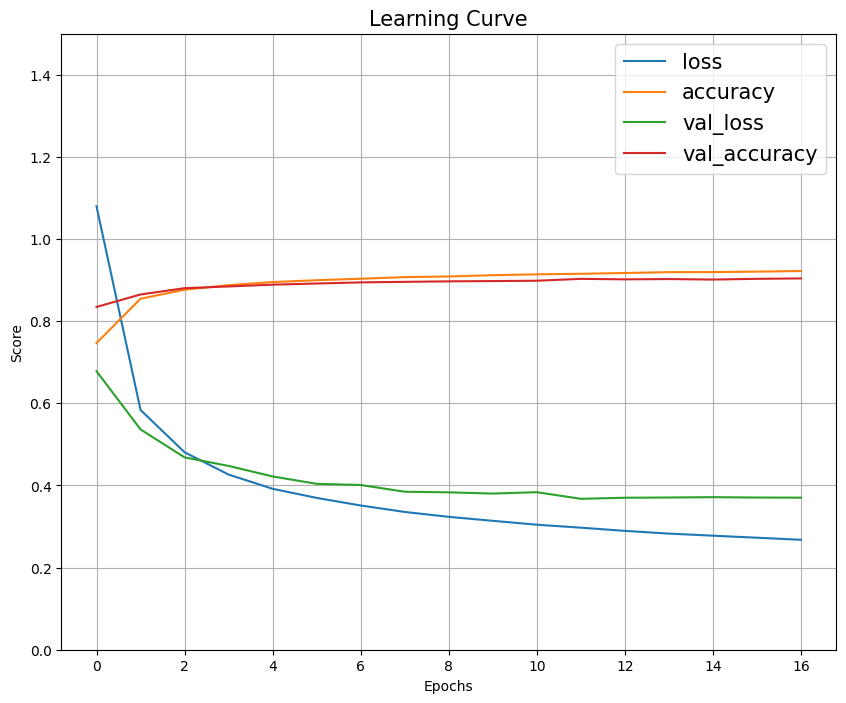

In [53]:
pd.DataFrame(history_H.history).plot(figsize=(10,8))
plt.title("Learning Curve", fontsize=15)
plt.legend(fontsize=15)
plt.ylim([0,1.5])
plt.ylabel('Score')
plt.xlabel('Epochs')
plt.grid()
plt.show()

In [54]:
# Valid Data
score = model.evaluate(X_val, y_val)

print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

1314/1314 [==============================] - 3s 2ms/step - loss: 0.3675 - accuracy: 0.9031
Validation loss: 0.3674735128879547
Validation accuracy: 0.9030585289001465


In [55]:
# Test data
score = model.evaluate(X_test, y_test)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

657/657 [==============================] - 2s 3ms/step - loss: 0.3591 - accuracy: 0.9032
Test loss: 0.35914984345436096
Test accuracy: 0.9032012820243835


In [31]:
def build_model(hp):

  # Backbone
  backbone = tka.ResNet50V2(include_top=False, weights='imagenet', input_shape=(*IMAGE_SIZE, 3))
  backbone.trainable = False

 # Initialize the model in sequential
  model = keras.Sequential()

  model.add(layers.InputLayer(input_shape=(*IMAGE_SIZE, 3), name="InputLayer"))
  model.add(backbone)

  # # Adding first convolutional layer
  # model.add(layers.Conv2D(
  #     filters=hp.Int('conv_1_filter', min_value=64, max_value=256, step=64),
  #     kernel_size=hp.Choice('conv_1_kernel', values=[3,5]),
  #     activation='relu',
  #     input_shape=(*IMAGE_SIZE,1)
  # ))
  # # Adding first pooling layer
  # model.add(layers.AvgPool2D(
  #     pool_size=(hp.Int('pool_1_size', min_value=2, max_value=3, step=1),
  #     hp.Int('pool_1_size', min_value=2, max_value=3, step=1))
  # ))

  # # Adding multiple convolutional and pooling layers
  # for i in range(hp.Choice('n_conv_layers', values=[1,2,3])):
  #   model.add(layers.Conv2D(
  #       filters=hp.Int(f'conv_{i+2}_filter', min_value=64, max_value=256, step=64),
  #       kernel_size=hp.Choice(f'conv_{i+2}_kernel', values=[3,5]),
  #       activation='relu',
  #   ))
  #   model.add(layers.AvgPool2D(
  #       pool_size=(hp.Int(f'pool_{i+2}_size', min_value=2, max_value=3, step=1),
  #       hp.Int(f'pool_{i+1}_size', min_value=2, max_value=3, step=1))
  #   ))

  model.add(layers.GlobalAveragePooling2D())

  # Adding multiple FC layers
  for i in range(hp.Int('n_FC_layers', min_value=1, max_value=3, step=1)):
    model.add(layers.Dense(hp.Choice(f'{i+1}_FC_layer', values=[64, 128, 256]),
                           activation='relu'))
  model.add(layers.Dropout(hp.Choice(f'{i+1}_dropout_layer', values=[0.2, 0.3, 0.5])))
  #model.add(layers.BatchNormalization())

  # Adding output layer
  model.add(layers.Dense(len(class_names), activation='softmax'))


  # Compile the model
  model.compile(loss='sparse_categorical_crossentropy',
                optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                metrics=['accuracy'])

  return model

In [33]:
# Initialize tuner
tuner = kt.RandomSearch(hypermodel=build_model, objective='val_accuracy', project_name='OCR-5_2')

# Start hyperparameter search.
tuner.search(X_train, y_train,
             validation_data=(X_val, y_val),
             epochs=5,  # Adjust as needed
             batch_size=BATCH_SIZE)

Trial 10 Complete [00h 04m 59s]
val_accuracy: 0.497122198343277

Best val_accuracy So Far: 0.8260238766670227
Total elapsed time: 00h 49m 35s


In [34]:
best_transfer_hps = tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values


for key, value in best_transfer_hps.items():
    print(f"{key}: {value}")

n_FC_layers: 2
1_FC_layer: 128
1_dropout_layer: 0.2
learning_rate: 0.001
2_FC_layer: 128
2_dropout_layer: 0.5


In [35]:
# Get the best model and build it
best_transfer_model = tuner.get_best_models()[0]
best_transfer_model.build(input_shape=(*IMAGE_SIZE, 1))

# Best Model Summary
best_transfer_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2, 2, 2048)        23564800  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 62)                7998      
                                                        

In [36]:
# Training the model
history_restnet = best_transfer_model.fit(X_train, y_train,
                         validation_data=(X_val, y_val),
                         epochs=100,
                         callbacks = [
        callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        callbacks.ModelCheckpoint(f'{model_dir}model_ocr_ResNet_v5_2.h5', save_best_only=True),
        callbacks.TensorBoard(f'{tensorboard_log_dir}{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}', histogram_freq=1)
    ]
)

Epoch 1/100
4598/4599 [============================>.] - ETA: 0s - loss: 0.6765 - accuracy: 0.8082

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4599/4599 [==============================] - 90s 19ms/step - loss: 0.6764 - accuracy: 0.8082 - val_loss: 0.6403 - val_accuracy: 0.8200
Epoch 2/100
4599/4599 [==============================] - 85s 19ms/step - loss: 0.6418 - accuracy: 0.8187 - val_loss: 0.6311 - val_accuracy: 0.8255
Epoch 3/100
4599/4599 [==============================] - 85s 18ms/step - loss: 0.6160 - accuracy: 0.8247 - val_loss: 0.6435 - val_accuracy: 0.8222
Epoch 4/100
4599/4599 [==============================] - 84s 18ms/step - loss: 0.5998 - accuracy: 0.8288 - val_loss: 0.6392 - val_accuracy: 0.8286
Epoch 5/100
4599/4599 [==============================] - 84s 18ms/step - loss: 0.5818 - accuracy: 0.8329 - val_loss: 0.6404 - val_accuracy: 0.8268
Epoch 6/100
4599/4599 [==============================] - 85s 18ms/step - loss: 0.5736 - accuracy: 0.8355 - val_loss: 0.6413 - val_accuracy: 0.8310
Epoch 7/100
4599/4599 [==============================] - 84s 18ms/step - loss: 0.5598 - accuracy: 0.8386 - val_loss: 0.6372 - val_

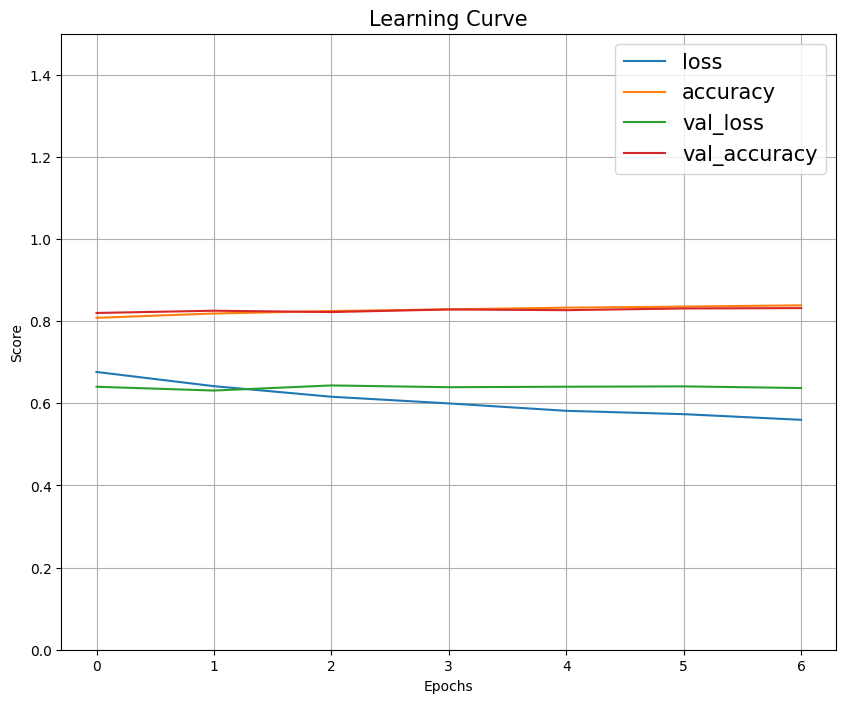

In [37]:
pd.DataFrame(history_restnet.history).plot(figsize=(10,8))
plt.title("Learning Curve", fontsize=15)
plt.legend(fontsize=15)
plt.ylim([0,1.5])
plt.ylabel('Score')
plt.xlabel('Epochs')
plt.grid()
plt.show()

In [38]:
# Valid Data
score = best_transfer_model.evaluate(X_val, y_val)

print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

1314/1314 [==============================] - 18s 14ms/step - loss: 0.6311 - accuracy: 0.8255
Validation loss: 0.6311045289039612
Validation accuracy: 0.8255006670951843


In [39]:
# Test data
score = best_transfer_model.evaluate(X_test, y_test)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

657/657 [==============================] - 9s 13ms/step - loss: 0.6364 - accuracy: 0.8237
Test loss: 0.6363826990127563
Test accuracy: 0.8237168788909912
